- 환경설정

In [77]:
from dotenv import load_dotenv
load_dotenv()

True

In [78]:
import os
os.environ["LANGCHAIN_PROJECT"] = "RAG"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [79]:
from langchain_teddynote import logging
logging.langsmith("RAG") # 추척 on
# logging.langsmith("RAG", set_enable=False) # 추척 off

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG


- 인덱싱 파이프라인 & RAG 체인

In [80]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

- 수집한 뉴스 링크를 불러온다.

In [100]:
import pandas as pd 
df = pd.read_csv('data/fraud_news.csv')
df.head()

,keyword,title,link,description,pubDate,collected_at
0,은행 사기,"트럼프 정부, '눈엣가시' 뉴욕검찰총장 기소 만지작",https://n.news.naver.com/mnews/article/001/001...,주택금융청 &quot;대출 <b>사기</b> 의혹&quot; 법무부에 수사 의뢰 미...,2025-04-17 20:51:00,2025-04-17 21:01:07
1,은행 사기,[이슈5] 내년 의대 '증원 0명'…&quot;이번이 복귀 마지막 기회&quot; 外,https://n.news.naver.com/mnews/article/422/000...,&lt;2&gt; 한국<b>은행</b> 금융통화위원회가 오늘(17일) 기준금리를 동...,2025-04-17 19:24:00,2025-04-17 21:01:07
2,은행 사기,"[2025 금융포럼] 글로벌 금융시장 경쟁력, AI 기술력이 결정한다",https://www.insightkorea.co.kr/news/articleVie...,이번 포럼에는 핀테크 회사뿐만 아니라 <b>은행</b> 등 전통금융사 IT·디지털·...,2025-04-17 19:04:00,2025-04-17 21:01:07
3,은행 사기,"[<b>은행</b> &amp; NOW] <b>은행</b>연합회, 미얀마 지진 피해 ...",https://www.ebn.co.kr/news/articleView.html?id...,금융사고와 <b>사기</b>위험으로부터 스마트폰을 안전하게 보호할 수 있다. 아울러...,2025-04-17 18:56:00,2025-04-17 21:01:07
4,은행 사기,"[기자수첩] 홈플러스 전단채 비대위, 피해 구제 위해선 소통 폭 넓혀야",http://www.lawissue.co.kr/view.php?ud=20250417...,비대위는 홈플러스 경영진을 특정경제범쥐 가중처벌 등에 관한 법률상 <b>사기</b>...,2025-04-17 18:32:00,2025-04-17 21:01:07


- 어떤 사이트에서 수집됐는지 확인

In [103]:
from urllib.parse import urlparse

# 도메인만 추출하는 함수수
def extract_hostname(url):
    try:
        parsed = urlparse(url)
        return parsed.netloc 
    
    except:
        return None

df['hostname'] = df['link'].apply(extract_hostname)

In [119]:
# 도메인별 기사 수 확인
with pd.option_context('display.max_rows', None):
    print(df['hostname'].value_counts())

hostname
n.news.naver.com                5992
m.entertain.naver.com            412
www.tokenpost.kr                 371
m.sports.naver.com               154
www.newspim.com                  150
www.etoday.co.kr                 120
www.g-enews.com                  119
www.smarttimes.co.kr             106
www.ajunews.com                   94
www.asiatoday.co.kr               83
www.digitaltoday.co.kr            79
www.asiatime.co.kr                77
www.newscj.com                    74
www.shinailbo.co.kr               72
biz.newdaily.co.kr                71
www.metroseoul.co.kr              71
www.kukinews.com                  71
www.viva100.com                   70
www.lawissue.co.kr                70
www.econovill.com                 65
www.widedaily.com                 63
www.pinpointnews.co.kr            61
www.naeil.com                     59
www.khgames.co.kr                 58
daily.hankooki.com                58
www.gametoc.co.kr                 57
www.enewstoday.co.kr         

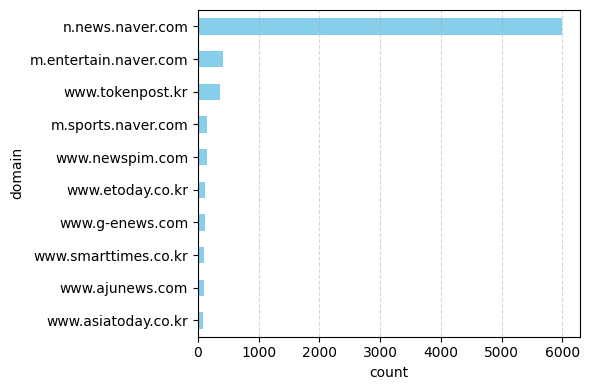

In [125]:
import matplotlib.pyplot as plt

# 도메인별 기사 수 계산 및 상위 10개 추출
host_counts = df['hostname'].value_counts().head(10)

# 시각화
plt.figure(figsize=(6, 4))
host_counts.plot(kind='barh', color='skyblue')
plt.xlabel("count")
plt.ylabel("domain")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- naver와 관련된 도메인만 남김
- 그 외 뉴스 사이트 추가는 추후 과제로...

In [126]:
df_naver = df[df['hostname'].str.contains("naver", case=False, na=False)]
print("전체 기사 수:", len(df))
print("Naver 관련 기사 수:", len(df_naver))

전체 기사 수: 15964
Naver 관련 기사 수: 6558


In [ ]:
df = df[df['hostname'].str.contains("naver", case=False, na=False)].reset_index(drop=True)

In [130]:
print(df['hostname'].value_counts())

hostname
n.news.naver.com         5992
m.entertain.naver.com     412
m.sports.naver.com        154
Name: count, dtype: int64


In [135]:
# 본문 크롤링 
def get_article_content(url):

    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                "div",
                attrs={"class": ["newsct_article _article_body", "media_end_head_title"]}
            )
        )
    )
    
    try:
        docs = loader.load()
    
        if docs:
            return docs[0].page_content.strip()
        else:
            return None
        
    except Exception as e:
        print(f"본문 추출 실패: {url}\n사유: {e}")
        return None

In [ ]:
df['contents'] = df['link'].apply(get_article_content)

- 질문을 포함하는 범위를 고려하여 쪼개지도록 최적화하는게 중요하다. 그 기준은 아무도 모른다. 해봐야 안다. 

In [49]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)

splits = text_splitter.split_documents(docs)

In [50]:
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# 뉴스에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

- hub에서 가져오거나

In [34]:
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

- 직접 작성하거나

In [69]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """당신은 질문-답변(Question-Answering)을 수행하는 친절한 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
한글로 답변해 주세요. 단, 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question} 

#Context: 
{context} 

#Answer:"""
)

- gpt-3.5-turbo : 영어로 처리할 때는 가성비가 좋음
- gpt-4-turbo-preview : 한글 처리 성능이 좋음

In [70]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0) 


def format_docs(docs):
    # 검색한 문서 결과를 하나의 문단으로 합쳐줍니다.
    return "\n\n".join(doc.page_content for doc in docs)


# 체인을 생성합니다.
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

- 기사 분류 / 요약 / 주요 특징 추출

In [71]:
input_question = """
1. 이 기사는 어떤 유형입니까? (범죄 사건 / 대응 정책 / 기타 중 하나로)
2. 주요 내용을 한 줄로 요약해 주세요.
3. (범죄 기사일 경우) 대표적인 범죄 유형은 무엇입니까?
4. (범죄 기사일 경우) 피해자의 특징이 있다면 알려주세요.
5. (범죄 기사일 경우) 피해 형태는 무엇입니까?
6. (범죄 기사일 경우) 발생 원인은 무엇입니까?
7. (대응 정책일 경우) 정책인가요, 기술적 대응인가요?

각 답변은 번호를 붙여서 한 줄로 주세요.
"""

In [72]:
print(
    rag_chain.invoke(input_question)
)  # 문서에 대한 질의를 입력하고, 답변을 출력합니다.

1. 범죄 사건
2. 트럼프 대통령의 뉴욕주 검찰총장 러티샤 제임스에 대한 대출 사기 의혹과 법무부 수사
3. 대표적인 범죄 유형은 대출 사기 의혹
4. 특징은 제공되지 않았습니다.
5. 피해 형태는 대출 사기 의혹
6. 발생 원인은 대출 사기 의혹
7. 정책인가요, 기술적 대응인가요? - 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.


- 스트리밍 출력
    - 단어 또는 문장을 생성하는 대로 바로바로 출력하는 방식

In [55]:
from langchain_teddynote.messages import stream_response

answer = rag_chain.stream("범죄 사건에 대한 기사인지 범죄 대응에 대한 기사인지 분류하세요.")
stream_response(answer)

범죄 사건에 대한 기사입니다.

- Run Chain 정리

In [56]:
question = "기사의 핵심 내용은 무엇인가요?"
response = rag_chain.invoke(question)

# 결과 출력
print(f"URL: {df['link'][0]}")
print(f"문서의 수: {len(docs)}")
print("===" * 20)
print(f"[HUMAN]\n{question}\n")
print(f"[AI]\n{response}")

URL: https://n.news.naver.com/mnews/article/001/0015337567?sid=104
문서의 수: 1
[HUMAN]
기사의 핵심 내용은 무엇인가요?

[AI]
러티샤 제임스 미 뉴욕주검찰총장에 대한 수사 요청과 법무부가 기소 여부를 검토하고 있다는 내용입니다.


- 결과 파싱

In [73]:
result = {
        "category": None,
        "summary": None,
        "crime_type": None,
        "victim_features": None,
        "damage": None,
        "cause": None,
        "response_type": None
    }

In [74]:
text = rag_chain.invoke(input_question)

In [75]:
import re

for i in range(1, 8):
    pattern = rf"{i}\.\s*(.*)"
    match = re.search(pattern, text)

    if match:
        value = match.group(1).strip()
        
        if i == 1:
            result["category"] = value
        elif i == 2:
            result["summary"] = value
        elif i == 3:
            result["crime_type"] = value
        elif i == 4:
            result["victim_features"] = value
        elif i == 5:
            result["damage"] = value
        elif i == 6:
            result["cause"] = value
        elif i == 7:
            result["response_type"] = value

In [76]:
result

{'category': '범죄 사건',
 'summary': '트럼프 대통령의 뉴욕주 검찰총장 러티샤 제임스에 대한 대출 사기 의혹과 법무부 수사',
 'crime_type': '대표적인 범죄 유형은 대출 사기 의혹',
 'victim_features': '피해자의 특징은 제임스 총장',
 'damage': '피해 형태는 대출 사기 의혹',
 'cause': '발생 원인은 대출 사기 의혹',
 'response_type': '정책인가요, 기술적 대응인가요?: 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.'}

- 전체 코드 (함수화)

In [ ]:
import re
import os
import bs4
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

# 1. 모델 설정
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# 2. 프롬프트 템플릿
prompt = PromptTemplate.from_template(
    """당신은 질문-답변(Question-Answering)을 수행하는 친절한 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
한글로 답변해 주세요. 단, 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

#Question: 
{question} 

#Context: 
{context} 

#Answer:"""
)

# 3. 분석 질문 템플릿
input_question = """
1. 이 기사는 어떤 유형입니까? (범죄 사건 / 대응 정책 / 기타 중 하나로)
2. 주요 내용을 한 줄로 요약해 주세요.
3. (범죄 기사일 경우) 대표적인 범죄 유형은 무엇입니까?
4. (범죄 기사일 경우) 피해자의 특징이 있다면 알려주세요.
5. (범죄 기사일 경우) 피해 형태는 무엇입니까?
6. (범죄 기사일 경우) 발생 원인은 무엇입니까?
7. (대응 정책일 경우) 정책인가요, 기술적 대응인가요?

각 답변은 번호를 붙여서 한 줄로 주세요.
"""

# 4. 문서 결합 함수
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 5. 파싱 함수
def parse_response(text):
    result = {
        "category": None,
        "summary": None,
        "crime_type": None,
        "victim_features": None,
        "damage": None,
        "cause": None,
        "response_type": None
    }

    for i in range(1, 8):
        match = re.search(rf"{i}\.\s*(.*)", text)
        if match:
            value = match.group(1).strip()
            match i:
                case 1: result["category"] = value
                case 2: result["summary"] = value
                case 3: result["crime_type"] = value
                case 4: result["victim_features"] = value
                case 5: result["damage"] = value
                case 6: result["cause"] = value
                case 7: result["response_type"] = value

    return result

# 6. 메인 분석 함수
def analyze_article_with_rag(documents, question=input_question):
    
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
    splits = splitter.split_documents(documents)

    vectorstore = FAISS.from_documents(splits, embedding=OpenAIEmbeddings())
    retriever = vectorstore.as_retriever()

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    response = rag_chain.invoke(question)
    return parse_response(response), response  # 구조화된 딕셔너리 + 원본문

- 문제점
    1. 네이버 뉴스 api로 가져왔지만 링크가 네이버가 아닌 뉴스도 있다(원문으로 가나봄) -> 네이버 관련 도메인만 남김
    2. 뉴스링크를 살펴보고 웹페이지 구조가 다를수 있기에 loader의 파싱속성을 수정해줘야 한다. 
    3. 오래 걸린다. 추후에는 새로 추가된 내용만 파싱할 수 있도록 해야 한다. 

In [145]:
# 본문 크롤링 
def get_article_content(url):

    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                "div",
                attrs={"class": ["newsct_article _article_body", "media_end_head_title"]}
            )
        )
    )
    
    try:
        return loader.load()
            
    except Exception as e:
        print(f"본문 추출 실패: {url}\n사유: {e}")
        return None
    
# docs[0].page_content.strip()

In [146]:
# 문서 로드
url = df['link'][0]
docs = get_article_content(url)
parsed, full_text = analyze_article_with_rag(docs)

print("\n[분석 결과 요약]")
for key, val in parsed.items():
    print(f"{key}: {val}")

print("\n[AI 전체 응답]")
print(full_text)

C:\Users\eros0\AppData\Local\Temp\ipykernel_28192\929126920.py:81: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = FAISS.from_documents(splits, embedding=OpenAIEmbeddings())



[분석 결과 요약]
category: 범죄 사건
summary: 트럼프 대통령의 뉴욕주 검찰총장 러티샤 제임스에 대한 수사와 기소 의혹
crime_type: 대표적인 범죄 유형은 대출 사기 의혹
victim_features: 특징은 러티샤 제임스 뉴욕주 검찰총장
damage: 피해 형태는 대출 사기 의혹
cause: 발생 원인은 대출 사기 의혹
response_type: 정책인가요, 기술적 대응인가요? - 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.

[AI 전체 응답]
1. 범죄 사건
2. 트럼프 대통령의 뉴욕주 검찰총장 러티샤 제임스에 대한 수사와 기소 의혹
3. 대표적인 범죄 유형은 대출 사기 의혹
4. 특징은 러티샤 제임스 뉴욕주 검찰총장
5. 피해 형태는 대출 사기 의혹
6. 발생 원인은 대출 사기 의혹
7. 정책인가요, 기술적 대응인가요? - 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.


In [ ]:
url = df['link']
print(f"문서 수: {len(url)}")

for i in range(len(url)):
    url = df.loc[i, "link"]
    try:
        docs = get_article_content(url)
        result_dict, _ = analyze_article_with_rag(docs)
        
        print(f"\n{url} 분석 결과 요약 완료")
        for key in result_dict:
            df.loc[i, key] = result_dict[key]
    except:
        continue

In [165]:
# 도메인별 기사 수 확인
with pd.option_context('display.max_colwidth', None):
    display(df[:5])

,keyword,title,link,description,pubDate,collected_at,hostname,category,summary,crime_type,victim_features,damage,cause,response_type
0,은행 사기,"트럼프 정부, '눈엣가시' 뉴욕검찰총장 기소 만지작",https://n.news.naver.com/mnews/article/001/0015337567?sid=104,주택금융청 &quot;대출 <b>사기</b> 의혹&quot; 법무부에 수사 의뢰 미국 정부가 도널드 트럼프 대통령의 정적 중 한명으로... 차례 <b>은행</b> 서류와 부동산 기록을 위조했다&quot;고 주장했다. 이들은 제임스 총장이 2023년 버지니아주 노퍽에 있는...,2025-04-17 20:51:00,2025-04-17 21:01:07,n.news.naver.com,범죄 사건,트럼프 대통령의 정적 중 한명으로 꼽히는 러티샤 제임스 뉴욕주 검찰총장에 대한 수사 요청과 법무부의 기소 여부 검토,대표적인 범죄 유형은 대출 사기 의혹,특징 없음,대출 사기 의혹,대출 사기 의혹,"정책인가요, 기술적 대응인가요? - 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다."
1,은행 사기,[이슈5] 내년 의대 '증원 0명'…&quot;이번이 복귀 마지막 기회&quot; 外,https://n.news.naver.com/mnews/article/422/0000732152?sid=102,&lt;2&gt; 한국<b>은행</b> 금융통화위원회가 오늘(17일) 기준금리를 동결했습니다. 그대로 2.75%를 유지하기로 한 건데요.... A씨는 앞선 경찰 조사에서 &quot;아파트 분양 사업 중 계약자들로부터 '<b>사기</b> 분양'으로 고소를 당해 엄청난 빚을...,2025-04-17 19:24:00,2025-04-17 21:01:07,n.news.naver.com,대응 정책,"의과대학 모집인원 증원 전 규모 확정, 기준금리 동결, 일가족 5명 살해 혐의로 구속된 50대 남성 A씨, '사교육 카르텔' 사건 발표, 봄 날씨 이어지고 주말에 비 소식",주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,"정책인가요, 기술적 대응인가요?: 정책"
2,은행 사기,헬리오시티·래미안슈르 '전세품귀'…&quot;매물 70% 줄어&quot;,https://n.news.naver.com/mnews/article/015/0005120729?sid=101,"전세<b>사기</b> 여파로 오피스텔, 빌라 등 비아파트 수요가 감소한 반면 아파트 전세 수요는 늘고 있다. 우리<b>은행</b>에 따르면 올 들어 지난 15일까지 아파트 전세 거래는 10만5005건으로, 월세(7만5074건)보다 많다. 월세에 반전세...",2025-04-17 18:22:00,2025-04-17 21:01:07,n.news.naver.com,기타,"수도권 전세 시장이 품귀 현상으로 전세가격 상승세를 보이고 있으며, 임대차 규제로 인해 전세 매물이 부족한 상황이다.",주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,대응 정책
3,은행 사기,&quot;월세로 세금 충당&quot;…임대인 脫전세 속도,https://n.news.naver.com/mnews/article/015/0005120727?sid=101,박원갑 국민<b>은행</b> 부동산수석전문위원은 “전세<b>사기</b> 여파로 빌라 전세 수요가 아파트로 넘어왔다”며 “전세보증금을 낮추고 월 임대료를 내는 식의 월세화가 이어지고 있다”고 설명했다. 월세 규모도 커지고 있다....,2025-04-17 18:21:00,2025-04-17 21:01:07,n.news.naver.com,대응 정책,"임대인들이 전세보다 월세를 선호하며, 부동산 세금을 월세로 충당하려는 현상이 뚜렷해지고 있다.",주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,정책
4,은행 사기,"‘이로운 연금 패키지’, 금리·건강 다 챙긴다",https://n.news.naver.com/mnews/article/382/0001191856?sid=101,"-‘이로운 연금 통장’, 최대 연 3% -5대 공적 연금 입금 시 우대금리 -‘50+걸어요’ 걸음 수 채우면 캐시 -피싱·해킹 <b>사기</b> 피해보험도 선봬 신한<b>은행</b>이 12월 24일까지 ‘신한 이로운 연금 패키지’를 판매한다. 연금...",2025-04-17 18:16:00,2025-04-17 21:01:07,n.news.naver.com,대응 정책,신한은행이 '신한 이로운 연금 패키지'를 판매하며 연금 수령 시니어 고객에게 맞춤형 금융 및 실질적 생활 혜택을 제공한다.,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다,"정책인가요, 기술적 대응인가요? - 주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다"


- 청크 사이즈에 미치지 못하는 너무 짧으면 split이 안되서 벡터스토어에 빈값이 들어갔음
- 문서 평균 길이 사이즈 확인 > 청크 사이즈 결정

In [177]:
len(docs[0].page_content)

1466